In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project


In [3]:

%cd /content/drive/MyDrive/ML_Project/learning-to-reweight-examples/

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
from data_loader2 import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})
import numpy as np
import os
import csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
hyperparameters = {
    'lr' : 0.1,
    'momentum' : 0.9,
    'batch_size' : 50,
    'num_iterations' : 1000,
}

In [6]:
data_loader = get_mnist_bkgnd_flip_loader(hyperparameters['batch_size'], mode="train")
test_loader = get_mnist_bkgnd_flip_loader(hyperparameters['batch_size'], mode="test")

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
#data_loader = get_mnist_unif_flip_loader(hyperparameters['batch_size'], mode="train")
#test_loader = get_mnist_unif_flip_loader(hyperparameters['batch_size'], mode="test")

In [8]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [9]:
val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)

In [10]:
print(val_labels.size())

torch.Size([100])


In [11]:
def build_model():
    net = LeNet(n_out=10)
    if os.path.isfile("mnist_bkgnd_reweight.pt"):
        net.load_state_dict(torch.load('mnist_bkgnd_reweight.pt'))
    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

In [12]:
net, opt = build_model()

net_losses = []
plot_step = 200
net_l = 0

smoothing_alpha = 0.9
lr_update = 1
accuracy_log = []
for i in tqdm(range(80000)):
    if i > 40000:
      lr_update = 0.1
    if i > 60000:
      lr_update = 0.01
    opt.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
    net.train()
    image, labels = next(iter(data_loader))

    image = to_var(image, requires_grad=False)
    labels = to_var(labels, requires_grad=False)

    y = net(image)
    cost = F.cross_entropy(y,labels.type(torch.LongTensor).cuda())
    
    opt.zero_grad()
    cost.backward()
    opt.step()
    
    net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* cost.item()
    net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))
    
    net_losses.append(cost.item())

    if i % plot_step == 0:
        net.eval()
        
        acc = []
        for itr,(test_img, test_label) in enumerate(test_loader):
            test_img = to_var(test_img, requires_grad=False)
            test_label = to_var(test_label, requires_grad=False)
            
            output = net(test_img)
            predicted = torch.argmax(output, dim = 1).int()
            
            acc.append((predicted.int() == test_label.int()).float())

        accuracy = torch.cat(acc,dim=0).mean()
        accuracy_log.append(np.array([i,accuracy.cpu()])[None])
        
        
        IPython.display.clear_output()
        fig, axes = plt.subplots(1, 2, figsize=(13,5))
        ax1, ax2 = axes.ravel()

        ax1.plot(net_losses, label='net_losses')
        ax1.set_ylabel("Losses")
        ax1.set_xlabel("Iteration")
        ax1.legend()
        
        acc_log = np.concatenate(accuracy_log, axis=0)
        ax2.plot(acc_log[:,0],acc_log[:,1])
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Iteration')
        plt.show()

with open('acc_log_baseline_mnist_bknd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, np.concatenate(accuracy_log, axis=0), delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_baseline_mnist_bknd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()

  0%|          | 0/80000 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

In [13]:
def train_lre():
    net, opt = build_model()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 200

    smoothing_alpha = 0.9

    accuracy_log = []
    lr_update = 1
    csv_net_losses = []
    csv_acc = []
    if os.path.isfile("acc_log_mnist_bknd_flip.csv"):
      with open("acc_log_mnist_bknd_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_mnist_bknd_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses.append(list(np.float_(row)))
      csv_file.close()

    csv_net_losses = np.array(csv_net_losses)
    csv_acc = np.array(csv_acc)

    for i in tqdm(range(iter_start,iter_end)):
        if i > 40000:
          lr_update = 0.1
        if i > 60000:
          lr_update = 0.01
        opt.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = LeNet(n_out=10)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels.type(torch.LongTensor), requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.cross_entropy(y_f_hat,labels.type(torch.LongTensor).cuda(),reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(lr_update*hyperparameters['lr'], source_params=grads)
        
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = meta_net(val_data)
        l_g_meta = F.cross_entropy(y_g_hat,val_labels.type(torch.LongTensor).cuda())
        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.cross_entropy(y_f_hat, labels.type(torch.LongTensor).cuda())
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        net_losses.append(l_f.item())

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                predicted = torch.argmax(output, dim = 1).int()
                acc.append((predicted.int() == test_label.int()).float())
            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy.cpu()])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            net_losses_plot = np.concatenate((csv_net_losses.flatten(),np.array(net_losses)), axis=0) if csv_net_losses.size else np.array(net_losses)
            ax1.plot(net_losses_plot, label='net_losses_reweighted')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate((csv_acc,np.concatenate(accuracy_log,axis=0)), axis=0) if csv_acc.size else np.concatenate(accuracy_log,axis=0)
            ax2.plot(acc_log[:,0],100*acc_log[:,1],label='accuracy_reweighted')
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()

    torch.save(net.state_dict(), 'mnist_bkgnd_reweight.pt')       
        # return accuracy
    return np.concatenate(accuracy_log, axis=0),net_losses

In [ ]:
iter_start = 25000
iter_end = 30000

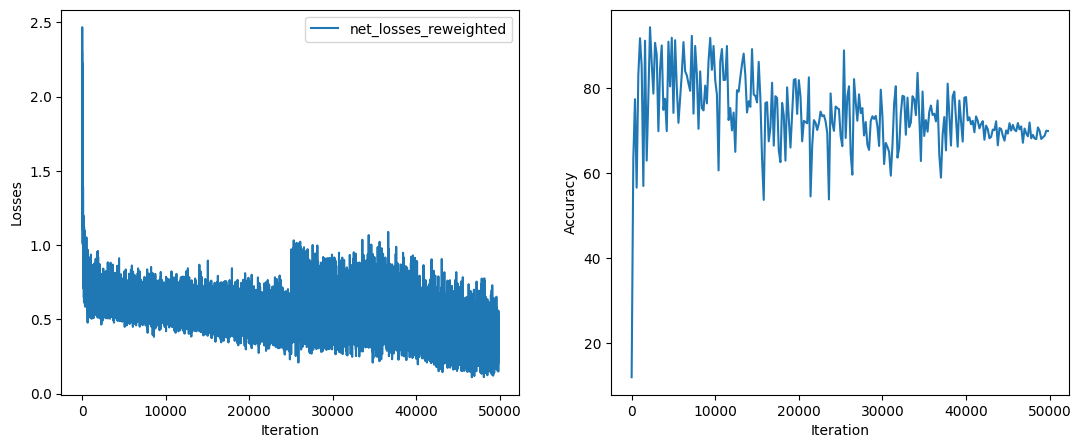

100%|██████████| 5000/5000 [48:48<00:00,  1.71it/s]


In [ ]:
acc_log, net_losses = train_lre()
with open('acc_log_mnist_bknd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_mnist_bknd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()